# Reconnaissance faciale avec SVM

## Étape 1 — Environnement et chargement des données

### 1.1 Imports (bibliothèques)

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import os

### 1.2 Définition des chemins

In [91]:
# Chemin du dossier contenant les sous-dossiers par personne (L4)
BASE_DIR = Path(r"./L4")

# Vérifier que le dossier existe
print(f"Dossier de base : {BASE_DIR.absolute()}")
print(f"Existe : {BASE_DIR.exists()}")

Dossier de base : C:\Users\DEBUZE DAVID\Documents\aaMes cours\L4\Premier semestre\Systeme intelligent\TP2\L4
Existe : True


### 1.3 Exploration du dataset

In [92]:
# Lister les sous-dossiers = noms des personnes (classes)
personnes = sorted([d.name for d in BASE_DIR.iterdir() if d.is_dir()])
# Exclure Caleb et Melvin (classes mal reconnues)
personnes = [p for p in personnes if p not in ("Caleb", "Melvin")]
print(f"Nombre de personnes (classes) : {len(personnes)}")
print(f"Noms : {personnes}")

# Nombre d'images par personne
for p in personnes:
    nb = len(list((BASE_DIR / p).glob("*.jpeg"))) + len(list((BASE_DIR / p).glob("*.jpg")))
    print(f"  {p} : {nb} images")

Nombre de personnes (classes) : 7
Noms : ['Beni', 'David', 'Grace', 'Jenovic', 'Michel', 'Ntwari', 'Strategie']
  Beni : 16 images
  David : 21 images
  Grace : 14 images
  Jenovic : 30 images
  Michel : 10 images
  Ntwari : 23 images
  Strategie : 25 images


### Aperçu des images originales (avant réduction 64×64)
Images telles qu'elles sont sur le disque, sans redimensionnement — pour comparaison avec la version 64×64 utilisée pour le modèle.

IndexError: list index out of range

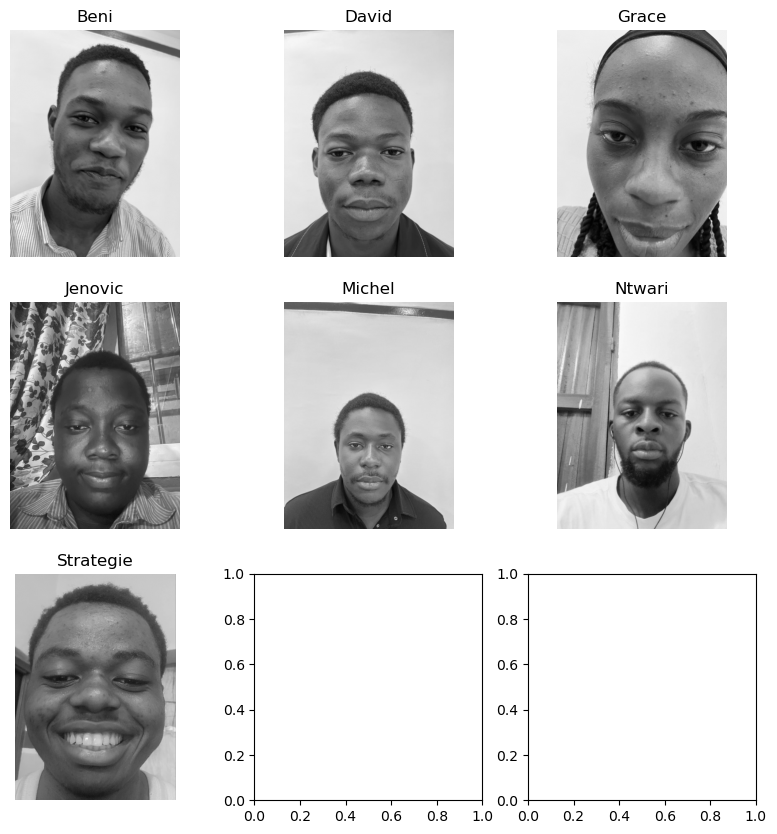

In [93]:
# Charger et afficher une image par personne à taille originale (sans 64×64)
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
    dossier = BASE_DIR / personnes[i]
    f = next(dossier.glob("*.jpeg"), None) or next(dossier.glob("*.jpg"))
    img = Image.open(f).convert("L")
    ax.imshow(img, cmap="gray")
    ax.set_title(personnes[i])
    ax.axis("off")

plt.tight_layout()
plt.show()

### 1.4 Chargement des images (niveaux de gris, taille fixe)

In [94]:
# Taille cible pour toutes les images (hauteur, largeur) — 128x128 pour plus de détails
IMG_SIZE = (128, 128)

def charger_image(chemin, size=IMG_SIZE):
    """Charge une image en niveaux de gris et la redimensionne."""
    img = Image.open(chemin).convert("L")
    img = img.resize(size)
    return np.array(img)

# Charger toutes les images et étiquettes
images = []
labels = []

for label, nom in enumerate(personnes):
    dossier = BASE_DIR / nom
    for ext in ("*.jpeg", "*.jpg"):
        for f in dossier.glob(ext):
            img = charger_image(f)
            images.append(img)
            labels.append(label)

print(f"Total images chargées : {len(images)}")
print(f"Forme d'une image : {images[0].shape}")

Total images chargées : 139
Forme d'une image : (128, 128)


### 1.5 Construction des tableaux X et y

In [95]:
# X : une ligne par image (vecteur aplati)
X = np.array(images).reshape(len(images), -1)
# y : étiquette (0, 1, 2, ...) pour chaque personne
y = np.array(labels)

print(f"X shape : {X.shape}")
print(f"y shape : {y.shape}")
print(f"Labels uniques : {np.unique(y)}")
print(f"Correspondance : {dict(zip(range(len(personnes)), personnes))}")

X shape : (139, 16384)
y shape : (139,)
Labels uniques : [0 1 2 3 4 5 6]
Correspondance : {0: 'Beni', 1: 'David', 2: 'Grace', 3: 'Jenovic', 4: 'Michel', 5: 'Ntwari', 6: 'Strategie'}


### Visualisation de quelques images (niveaux de gris)

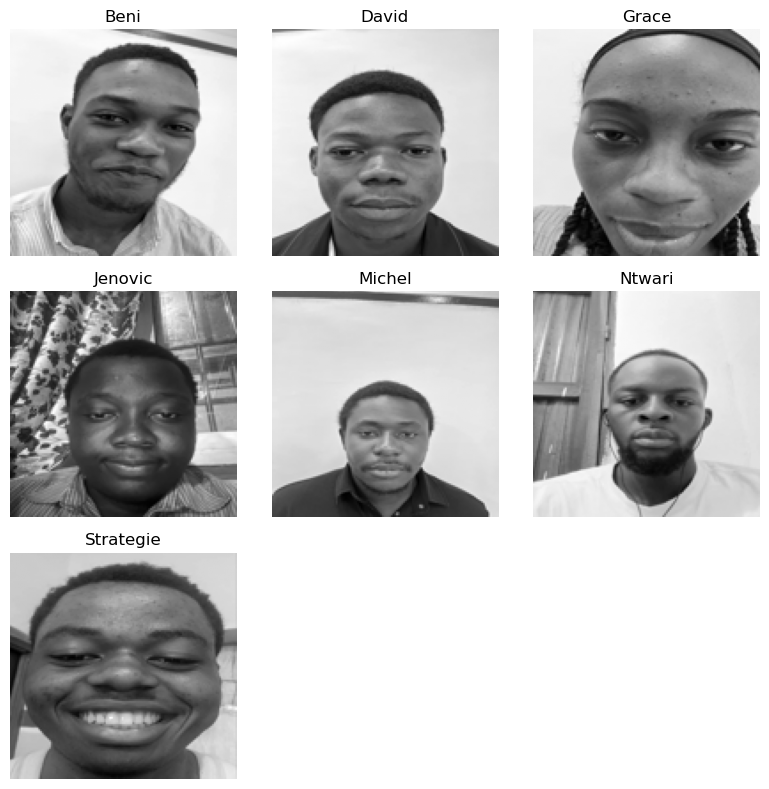

In [96]:
# Afficher une image par personne
fig, axes = plt.subplots(3, 3, figsize=(8, 8))

for i, ax in enumerate(axes.flat):
    if i >= len(personnes):
        ax.set_visible(False)
        continue
    idx = np.where(y == i)[0][0]
    ax.imshow(images[idx], cmap="gray")
    ax.set_title(personnes[i])
    ax.axis("off")

plt.tight_layout()
plt.show()

## Étape 2 — Prétraitement et réduction de dimension

### 2.1 Imports (sklearn)

In [97]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

### 2.2 Normalisation (centrer-réduire)

In [98]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("X_scaled shape:", X_scaled.shape)
print("Moyenne (proche de 0):", X_scaled.mean(axis=0).mean().round(4))
print("Écart-type (proche de 1):", X_scaled.std(axis=0).mean().round(4))

X_scaled shape: (139, 16384)
Moyenne (proche de 0): -0.0
Écart-type (proche de 1): 1.0


In [99]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.20, stratify=y, random_state=42
)

print(f"Train : {X_train.shape[0]} images")
print(f"Test  : {X_test.shape[0]} images")

Train : 111 images
Test  : 28 images


### 2.4 Réduction de dimension (PCA)
On réduit le nombre de features pour accélérer l'SVM tout en gardant la majeure partie de l'information (variance).

In [100]:
# Garder 95 % de la variance (ou fixer n_components=80 par ex.)
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

print(f"Composantes retenues : {X_train_pca.shape[1]} (au lieu de {X_train.shape[1]})")
print(f"Variance expliquée cumulée : {pca.explained_variance_ratio_.sum():.2%}")

Composantes retenues : 71 (au lieu de 16384)
Variance expliquée cumulée : 95.09%


## Étape 3 — Entraînement du modèle SVM

### 3.1 Création du classifieur SVM (noyau linéaire)

In [101]:
from sklearn.svm import SVC

# Noyau linéaire : rapide et adapté quand les classes sont séparables
model = SVC(kernel="linear", C=1.0, random_state=42)
print("Modèle :", model)

Modèle : SVC(kernel='linear', random_state=42)


### 3.2 Entraînement sur les données PCA

In [68]:
model.fit(X_train_pca, y_train)
print("Entraînement terminé.")

Entraînement terminé.


## Étape 4 — Évaluation et analyse des résultats

### 4.1 Prédictions sur le jeu de test

In [69]:
y_pred = model.predict(X_test_pca)
print("Prédictions (labels):", y_pred[:15], "...")
print("Vrais labels        :", y_test[:15], "...")

Prédictions (labels): [0 5 0 1 2 6 0 3 4 0 4 0 6 1 2] ...
Vrais labels        : [0 5 1 1 2 6 0 3 4 0 4 2 6 1 2] ...


### 4.2 Métriques (accuracy, rapport de classification)

In [70]:
from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy sur le test : {accuracy:.2%}\n")
print("Rapport par classe (personne) :")
print(classification_report(y_test, y_pred, target_names=personnes))

Accuracy sur le test : 90.00%

Rapport par classe (personne) :
              precision    recall  f1-score   support

        Beni       0.60      1.00      0.75         3
       David       1.00      0.75      0.86         4
       Grace       1.00      0.67      0.80         3
     Jenovic       1.00      1.00      1.00         3
      Michel       1.00      1.00      1.00         2
      Ntwari       1.00      1.00      1.00         2
   Strategie       1.00      1.00      1.00         3

    accuracy                           0.90        20
   macro avg       0.94      0.92      0.92        20
weighted avg       0.94      0.90      0.90        20



### 4.3 Matrice de confusion (visualisation)

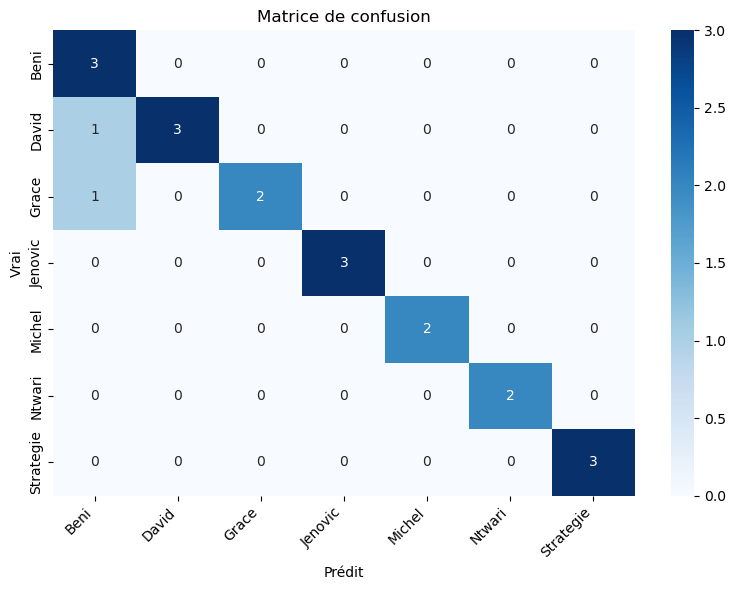

In [71]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=personnes, yticklabels=personnes)
plt.xlabel("Prédit")
plt.ylabel("Vrai")
plt.title("Matrice de confusion")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

## Étape 5 — Sauvegarde du modèle et prédiction sur de nouvelles images

### 5.1 Sauvegarde du modèle, du scaler et de la PCA

In [72]:
import joblib

# Sauvegarder pour réutilisation sans réentraîner
joblib.dump(model, "model_svm_facial.joblib")
joblib.dump(scaler, "scaler_facial.joblib")
joblib.dump(pca, "pca_facial.joblib")
joblib.dump(personnes, "personnes_facial.joblib")

print("Sauvegardé : model_svm_facial.joblib, scaler_facial.joblib, pca_facial.joblib, personnes_facial.joblib")

Sauvegardé : model_svm_facial.joblib, scaler_facial.joblib, pca_facial.joblib, personnes_facial.joblib


### 5.2 Correspondance label → nom (personnes)

In [73]:
# Label 0 → personnes[0], label 1 → personnes[1], etc.
label_to_name = dict(zip(range(len(personnes)), personnes))
print("Correspondance label → nom :", label_to_name)

Correspondance label → nom : {0: 'Beni', 1: 'David', 2: 'Grace', 3: 'Jenovic', 4: 'Michel', 5: 'Ntwari', 6: 'Strategie'}


### 5.3 Prédire une nouvelle image (exemple : une image du dossier L4)
Charge une image, applique le même prétraitement (taille, gris, scaler, PCA) et affiche la personne prédite.

In [74]:
def predire_visage(chemin_image, modele, scaler, pca, noms_personnes, img_size=IMG_SIZE):
    """Charge une image, prétraite et retourne le nom prédit."""
    img = Image.open(chemin_image).convert("L")
    img = img.resize(img_size)
    x = np.array(img).reshape(1, -1)
    x = scaler.transform(x)
    x_pca = pca.transform(x)
    label = modele.predict(x_pca)[0]
    return noms_personnes[label]

# Exemple : prendre la première image de David
exemple = BASE_DIR / "David" / next((BASE_DIR / "David").glob("*.jpeg")).name
nom_pred = predire_visage(exemple, model, scaler, pca, personnes)
print(f"Image : {exemple.name}")
print(f"Personne prédite : {nom_pred}")

Image : WhatsApp Image 2026-02-07 at 14.06.25 (1).jpeg
Personne prédite : David


### Test en direct avec la caméra
Ouvre la caméra : affiche la prévisualisation, appuie sur **S** pour prendre une photo, le modèle prédit la personne puis la fenêtre se ferme. (Nécessite `opencv-python` : `pip install opencv-python`.)

In [90]:
import cv2

cap = cv2.VideoCapture(0)
if not cap.isOpened():
    print("Impossible d'ouvrir la caméra.")
else:
    print("Prévisualisation : appuie sur S pour prendre la photo, ECHAP pour quitter sans photo.")
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        affichage = frame.copy()
        cv2.putText(affichage, "S = photo | ECHAP = quitter", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        cv2.imshow("Caméra - reconnaissance faciale", affichage)
        key = cv2.waitKey(1) & 0xFF
        if key == 27:  # ECHAP
            break
        if key == ord("s") or key == ord("S"):
            # Prendre la photo : gris, redimensionner, prétraiter, prédire
            img_gris = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            img_128 = cv2.resize(img_gris, IMG_SIZE)
            x = img_128.reshape(1, -1)
            x = scaler.transform(x)
            x_pca = pca.transform(x)
            label = model.predict(x_pca)[0]
            nom_pred = personnes[label]
            print(f"Personne prédite : {nom_pred}")
            cv2.putText(frame, f"Prediction: {nom_pred}", (10, 40), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 2)
            cv2.imshow("Photo prise", frame)
            cv2.waitKey(3000)
            break
    cap.release()
    cv2.destroyAllWindows()

Prévisualisation : appuie sur S pour prendre la photo, ECHAP pour quitter sans photo.


### Prédiction sur les images du dossier Test
Charge toutes les images du dossier `Test`, applique le même prétraitement et affiche la prédiction pour chaque image.

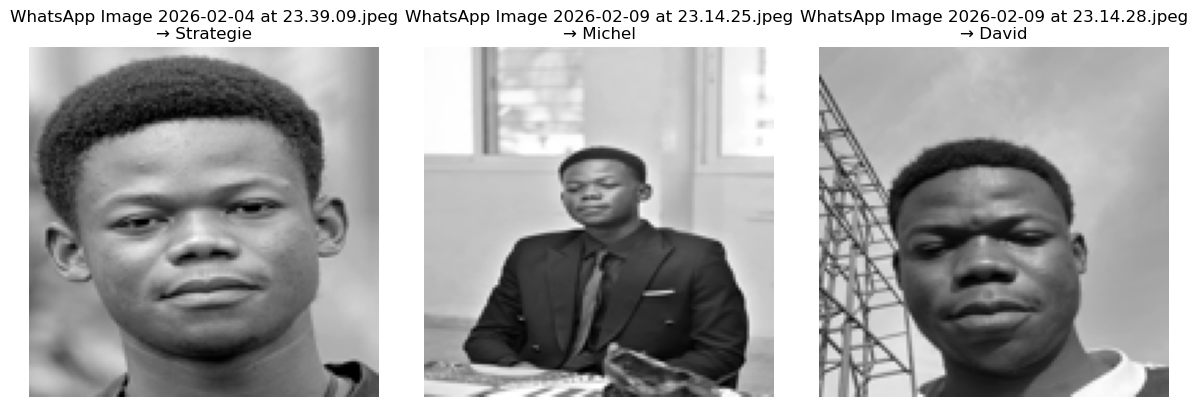

Résumé des prédictions :
  WhatsApp Image 2026-02-04 at 23.39.09.jpeg  →  Strategie
  WhatsApp Image 2026-02-09 at 23.14.25.jpeg  →  Michel
  WhatsApp Image 2026-02-09 at 23.14.28.jpeg  →  David


In [89]:
TEST_DIR = Path("./Test")
fichiers = list(TEST_DIR.glob("*.jpeg")) + list(TEST_DIR.glob("*.jpg"))
if not fichiers:
    print("Aucune image (.jpeg/.jpg) trouvée dans le dossier Test.")
else:
    n = len(fichiers)
    n_cols = min(4, n)
    n_rows = (n + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))
    axes = np.atleast_2d(axes)
    axes_flat = axes.flatten()
    for i, f in enumerate(fichiers):
        img = Image.open(f).convert("L").resize(IMG_SIZE)
        x = np.array(img).reshape(1, -1)
        x = scaler.transform(x)
        x_pca = pca.transform(x)
        label = model.predict(x_pca)[0]
        nom_pred = personnes[label]
        axes_flat[i].imshow(img, cmap="gray")
        axes_flat[i].set_title(f"{f.name}\n→ {nom_pred}")
        axes_flat[i].axis("off")
    for j in range(n, len(axes_flat)):
        axes_flat[j].set_visible(False)
    plt.tight_layout()
    plt.show()
    print("Résumé des prédictions :")
    for f in fichiers:
        img = Image.open(f).convert("L").resize(IMG_SIZE)
        x = np.array(img).reshape(1, -1)
        x = scaler.transform(x)
        x_pca = pca.transform(x)
        nom_pred = personnes[model.predict(x_pca)[0]]
        print(f"  {f.name}  →  {nom_pred}")